**Student name: Giorgi Guledani**

**Student ID: 20193667**

# Lecture 5: Research 2: Will personalized Long Tail items further improve the recommender model?

This notebook builds upon the previous research question: "How to address the Long Tail Problem?".

In [1]:
import pandas as pd
import utils
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

articles = pd.read_parquet(f'{utils.path}/articles.parquet')
customers = pd.read_parquet(f'{utils.path}/customers.parquet')
transactions = pd.read_parquet(f'{utils.path}/transactions_train.parquet')

# Parameters

In [2]:
K = 1 # amount of items to replace Short Head items with personalized Long Tail items, if customer made atleast 1 Long Tail item purchase

# threshold for identifying long tail items. Total item sale counts below or equal to this threshold are marked as Long Tail
# if None, the mean of all item sale counts is taken as the threshold (= threshold in the middle)
alpha = 2000

# Identifying short head and long tail items

Like previously, we have to first identify the Long Tail items

In [3]:

# Determine the threshold for the top half
transactions_count = transactions.groupby(["article_id"])["article_id"].value_counts(dropna=False)
if not "long_tail" in articles.columns:
    articles = articles.merge(transactions.groupby(['article_id'])["article_id"].value_counts(dropna=False), left_on ="article_id", how="left", right_index=True)
    articles["count"].fillna(0, inplace=True)
    articles = articles.rename(columns={"count": "sales_count"})
    if alpha is None:
        threshold = articles["sales_count"].median()
    else:
        threshold = alpha 
    print(f"Threshold (alpha): {threshold}")
    articles["long_tail"] = (articles["sales_count"] <= threshold).astype(int)
transactions[transactions["article_id"] == 351484039]


Threshold (alpha): 2000


,t_dat,customer_id,article_id,price,sales_channel_id,week
22279468,2020-02-12,7993556869309464686,351484039,0.022017,2,73
22307079,2020-02-13,11693170829426928559,351484039,0.022017,2,73
22326267,2020-02-13,14251597971675452778,351484039,0.022017,2,73
22333826,2020-02-14,11322089096702754811,351484039,0.022017,2,73
22333814,2020-02-14,17298776028320583102,351484039,0.019814,2,73
...,...,...,...,...,...,...
31773893,2020-09-22,13118523669876511337,351484039,0.022017,2,104
31780827,2020-09-22,15473878317449867690,351484039,0.022017,2,104
31757413,2020-09-22,16551754216385484410,351484039,0.022017,2,104
31757898,2020-09-22,17214430568995933187,351484039,0.011000,1,104


Amount of Long Tail and Short Head items:

In [4]:
articles["long_tail"].value_counts()

long_tail
1    102919
0      2623
Name: count, dtype: int64

Items below the threshold get classified as long tail:

In [5]:
sorted_articles = articles[["article_id", "sales_count"]].sort_values(by="sales_count", ascending=False)

sorted_articles.reset_index(drop=True, inplace=True)
sorted_articles

,article_id,sales_count
0,706016001,50287.0
1,706016002,35043.0
2,372860001,31718.0
3,610776002,30199.0
4,759871002,26329.0
...,...,...
105537,926010001,0.0
105538,896195002,0.0
105539,917203001,0.0
105540,917203003,0.0


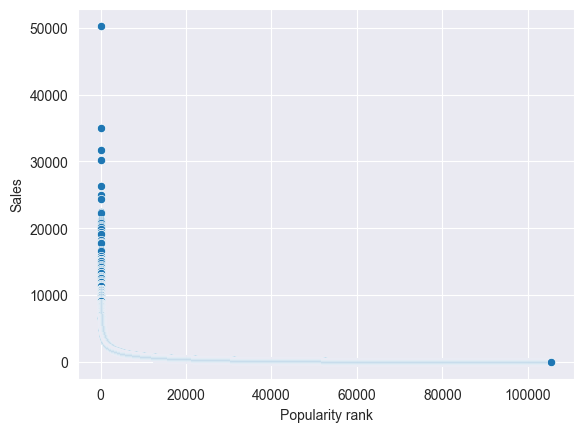

,article_id,sales_count
0,706016001,50287.0
1,706016002,35043.0
2,372860001,31718.0
3,610776002,30199.0
4,759871002,26329.0
...,...,...
105537,926010001,0.0
105538,896195002,0.0
105539,917203001,0.0
105540,917203003,0.0


In [6]:
sns.scatterplot(y=sorted_articles["sales_count"], x=sorted_articles.index)
# plt.gca().invert_xaxis()  # To reverse the x-axis

plt.xlabel("Popularity rank")
plt.ylabel("Sales")
plt.show()

plt.show()
sorted_articles

The scatterplot shows us that there's a select few in the short head part, while a huge amount is in the long tail part.

# Candidate Generation

In [7]:
test_week = transactions.week.max() + 1
transactions = transactions[transactions.week > transactions.week.max() - 10]

### Last purchase candidates

In [8]:
%%time

c2weeks = transactions.groupby('customer_id')['week'].unique()
transactions.groupby('week')['t_dat'].agg(['min', 'max'])

c2weeks2shifted_weeks = {}

for c_id, weeks in c2weeks.items():
    c2weeks2shifted_weeks[c_id] = {}
    for i in range(weeks.shape[0]-1):
        c2weeks2shifted_weeks[c_id][weeks[i]] = weeks[i+1]
    c2weeks2shifted_weeks[c_id][weeks[-1]] = test_week
    
candidates_last_purchase = transactions.copy()

weeks = []
for i, (c_id, week) in enumerate(zip(transactions['customer_id'], transactions['week'])):
    weeks.append(c2weeks2shifted_weeks[c_id][week])
    
candidates_last_purchase.week=weeks

CPU times: total: 25.3 s
Wall time: 25.4 s


### Bestsellers candidates

In [9]:
mean_price = transactions \
.groupby(['week', 'article_id'])['price'].mean()

In [10]:
mean_price

week  article_id
95    108775015     0.004729
      108775044     0.008458
      110065001     0.006085
      110065002     0.006085
      111565001     0.004288
                      ...   
104   952267001     0.013732
      952938001     0.048651
      953450001     0.016932
      953763001     0.021885
      956217002     0.059068
Name: price, Length: 196880, dtype: float32

In [11]:
sales = transactions \
    .groupby('week')['article_id'].value_counts() \
    .groupby('week').rank(method='dense', ascending=False) \
    .groupby('week').head(12).rename('bestseller_rank').astype('int8')

In [12]:
sales

week  article_id
95    760084003      1
      866731001      2
      600886001      3
      706016001      4
      372860002      5
                    ..
104   915529003      8
      915529005      9
      448509014     10
      762846027     11
      714790020     12
Name: bestseller_rank, Length: 120, dtype: int8

In [13]:
sales_frame = sales.to_frame().reset_index() # DataFrame is easier to use than Series (from Radek), so I'll use this from now on


In [14]:
sales_frame = sales_frame.merge(articles[["article_id", "long_tail"]], on="article_id", how="inner")

In [15]:
sales_frame["long_tail"].value_counts()


long_tail
0    84
1    36
Name: count, dtype: int64

### Personalizing candidates: KNN

We now have to personalize these candidates for users who bought Long Tail item(s) previously. Radek uses popular items from the last week (=test week) to recommend to all users, even those who didn't make purchases, hence the candidate generation for the test week will remain unchanged.

In [16]:
transactions

,t_dat,customer_id,article_id,price,sales_channel_id,week
29030503,2020-07-15,272412481300040,778064028,0.008458,1,95
29030504,2020-07-15,272412481300040,816592008,0.016932,1,95
29030505,2020-07-15,272412481300040,621381021,0.033881,1,95
29030506,2020-07-15,272412481300040,817477003,0.025407,1,95
29030507,2020-07-15,272412481300040,899088002,0.025407,1,95
...,...,...,...,...,...,...
31774722,2020-09-22,18439937050817258297,891591003,0.084729,2,104
31774723,2020-09-22,18439937050817258297,869706005,0.084729,2,104
31779097,2020-09-22,18440902715633436014,918894002,0.016932,1,104
31779098,2020-09-22,18440902715633436014,761269001,0.016932,1,104


In [17]:
top_long_tail = articles[articles["long_tail"]==1][["article_id", "sales_count"]].sort_values(by="sales_count", ascending=False).head(1000).reset_index()
top_long_tail_transactions = top_long_tail.merge(transactions[["article_id", "customer_id", "week"]], on='article_id', how='inner') # inner drops row if article never bought

top_long_tail_transactions

,index,article_id,sales_count,customer_id,week
0,87446,827907001,2000.0,1155273576847131497,95
1,87446,827907001,2000.0,1544020276116048112,95
2,87446,827907001,2000.0,2709255152936586007,95
3,87446,827907001,2000.0,5392980473272375639,95
4,87446,827907001,2000.0,5794016310180579503,95
...,...,...,...,...,...
120828,83833,813538002,1658.0,4314880535793909958,103
120829,83833,813538002,1658.0,9905136349707104371,103
120830,83833,813538002,1658.0,10091711478649023356,103
120831,83833,813538002,1658.0,12380247308394758761,103


To make this computationally less expensive, I will take the most popular long tail item purchase per user

In [18]:
top_long_tail_transaction_per_user = top_long_tail_transactions.groupby(["customer_id", "week"]).head(1)

Now we have a list of top long tail purchases per user and week. For example, a user bought 2 items part of the top 1000 in 2 different weeks:

In [19]:
top_long_tail_transaction_per_user


,index,article_id,sales_count,customer_id,week
0,87446,827907001,2000.0,1155273576847131497,95
1,87446,827907001,2000.0,1544020276116048112,95
2,87446,827907001,2000.0,2709255152936586007,95
3,87446,827907001,2000.0,5392980473272375639,95
4,87446,827907001,2000.0,5794016310180579503,95
...,...,...,...,...,...
120827,83833,813538002,1658.0,12043416092198402164,103
120828,83833,813538002,1658.0,4314880535793909958,103
120830,83833,813538002,1658.0,10091711478649023356,103
120831,83833,813538002,1658.0,12380247308394758761,103


In [20]:
top_long_tail_transaction_per_user[top_long_tail_transaction_per_user["week"]==96]["customer_id"].value_counts()


customer_id
845940109071444979      1
4849593994785800338     1
14540883457586789388    1
15194933563374499573    1
16463112080382572093    1
                       ..
3428687595783783237     1
6253896767976887253     1
7938846267417496365     1
12193395328291788780    1
17910290199070732775    1
Name: count, Length: 11838, dtype: int64

In [21]:
transactions[transactions["customer_id"]==107976824977578416]

,t_dat,customer_id,article_id,price,sales_channel_id,week


### K-Nearest Neighbours

We will replace top k bestseller items with k personalized long tail items.

Step 1: Create user-item interaction matrix

In [22]:
# interaction matrix will give cell a value of 1 if user interacted with an item
top_long_tail_interactions_matrix=top_long_tail_transaction_per_user.pivot_table(index="article_id", columns="customer_id", aggfunc=lambda x: 1, fill_value=0) 
top_long_tail_interactions_matrix

index                                            \
customer_id 116809474287335      272412481300040      330092272649261        
article_id                                                                   
153115021                      0                    0                    0   
156227001                      0                    0                    0   
188183016                      0                    0                    0   
214844003                      0                    0                    0   
228257004                      0                    0                    0   
...                          ...                  ...                  ...   
913030001                      0                    0                    0   
915529001                      0                    0                    0   
918292004                      0                    0                    0   
918522001                      0                    0                    0   
924243001                      0                    0                    0   

                                                                            \
customer_id 690285180337957      745180086074610      879819981624203        
article_id                                                                   
153115021                      0                    0                    0   
156227001                      0                    0                    0   
188183016                      0                    0                    0   
214844003                      0                    0                    0   
228257004                      0                    0                    0   
...                          ...                  ...                  ...   
913030001                      0                    0                    0   
915529001                      1                    0                    0   
918292004                      0                    0                    0   
918522001                      0                    0                    0   
924243001                      0                    0                    0   

                                                                            \
customer_id 1296218836199721     1394073833551710     1773900972412728       
article_id                                                                   
153115021                      0                    0                    0   
156227001                      0                    0                    0   
188183016                      0                    0                    0   
214844003                      0                    0                    0   
228257004                      0                    0                    0   
...                          ...                  ...                  ...   
913030001                      0                    0                    0   
915529001                      0                    0                    0   
918292004                      0                    0                    0   
918522001                      0                    0                    0   
924243001                      0                    0                    0   

                                  ...                 week  \
customer_id 1905990147027598      ... 18443414166633689256   
article_id                        ...                        
153115021                      0  ...                    0   
156227001                      0  ...                    0   
188183016                      0  ...                    0   
214844003                      0  ...                    0   
228257004                      0  ...                    0   
...                          ...  ...                  ...   
913030001                      0  ...                    0   
915529001                      0  ...                    0   
918292004                      1  ...                    0   
9185

Amount of 1's in matrix:

In [23]:
top_long_tail_interactions_matrix.values.sum()

287811

Step 2: computed cosine similarities

In [24]:
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import numpy as np

KNN = NearestNeighbors(algorithm="brute", metric="cosine").fit(csr_matrix(top_long_tail_interactions_matrix)) # huge increase in speed when using csr_matrix!
top_long_tail_interactions_matrix

index                                            \
customer_id 116809474287335      272412481300040      330092272649261        
article_id                                                                   
153115021                      0                    0                    0   
156227001                      0                    0                    0   
188183016                      0                    0                    0   
214844003                      0                    0                    0   
228257004                      0                    0                    0   
...                          ...                  ...                  ...   
913030001                      0                    0                    0   
915529001                      0                    0                    0   
918292004                      0                    0                    0   
918522001                      0                    0                    0   
924243001                      0                    0                    0   

                                                                            \
customer_id 690285180337957      745180086074610      879819981624203        
article_id                                                                   
153115021                      0                    0                    0   
156227001                      0                    0                    0   
188183016                      0                    0                    0   
214844003                      0                    0                    0   
228257004                      0                    0                    0   
...                          ...                  ...                  ...   
913030001                      0                    0                    0   
915529001                      1                    0                    0   
918292004                      0                    0                    0   
918522001                      0                    0                    0   
924243001                      0                    0                    0   

                                                                            \
customer_id 1296218836199721     1394073833551710     1773900972412728       
article_id                                                                   
153115021                      0                    0                    0   
156227001                      0                    0                    0   
188183016                      0                    0                    0   
214844003                      0                    0                    0   
228257004                      0                    0                    0   
...                          ...                  ...                  ...   
913030001                      0                    0                    0   
915529001                      0                    0                    0   
918292004                      0                    0                    0   
918522001                      0                    0                    0   
924243001                      0                    0                    0   

                                  ...                 week  \
customer_id 1905990147027598      ... 18443414166633689256   
article_id                        ...                        
153115021                      0  ...                    0   
156227001                      0  ...                    0   
188183016                      0  ...                    0   
214844003                      0  ...                    0   
228257004                      0  ...                    0   
...                          ...  ...                  ...   
913030001                      0  ...                    0   
915529001                      0  ...                    0   
918292004                      1  ...                    0   
9185

In [25]:
top_long_tail_interactions_matrix

index                                            \
customer_id 116809474287335      272412481300040      330092272649261        
article_id                                                                   
153115021                      0                    0                    0   
156227001                      0                    0                    0   
188183016                      0                    0                    0   
214844003                      0                    0                    0   
228257004                      0                    0                    0   
...                          ...                  ...                  ...   
913030001                      0                    0                    0   
915529001                      0                    0                    0   
918292004                      0                    0                    0   
918522001                      0                    0                    0   
924243001                      0                    0                    0   

                                                                            \
customer_id 690285180337957      745180086074610      879819981624203        
article_id                                                                   
153115021                      0                    0                    0   
156227001                      0                    0                    0   
188183016                      0                    0                    0   
214844003                      0                    0                    0   
228257004                      0                    0                    0   
...                          ...                  ...                  ...   
913030001                      0                    0                    0   
915529001                      1                    0                    0   
918292004                      0                    0                    0   
918522001                      0                    0                    0   
924243001                      0                    0                    0   

                                                                            \
customer_id 1296218836199721     1394073833551710     1773900972412728       
article_id                                                                   
153115021                      0                    0                    0   
156227001                      0                    0                    0   
188183016                      0                    0                    0   
214844003                      0                    0                    0   
228257004                      0                    0                    0   
...                          ...                  ...                  ...   
913030001                      0                    0                    0   
915529001                      0                    0                    0   
918292004                      0                    0                    0   
918522001                      0                    0                    0   
924243001                      0                    0                    0   

                                  ...                 week  \
customer_id 1905990147027598      ... 18443414166633689256   
article_id                        ...                        
153115021                      0  ...                    0   
156227001                      0  ...                    0   
188183016                      0  ...                    0   
214844003                      0  ...                    0   
228257004                      0  ...                    0   
...                          ...  ...                  ...   
913030001                      0  ...                    0   
915529001                      0  ...                    0   
918292004                      1  ...                    0   
9185

Step 3: personalize k bestseller items

Since it's item-based, items will be similar to each other no matter the user. So only unique IDs are picked to make computation less expensive.

In [26]:
unique_top_long_tail = top_long_tail_transaction_per_user["article_id"].unique()
unique_top_long_tail

array([827907001, 624486010, 673799003, 681179002, 433444001, 693243002,
       832114002, 564448002, 536139047, 568597023, 817361006, 811835009,
       695632033, 464927018, 794007001, 821336002, 803592003, 695632101,
       735607002, 664461007, 685813018, 678942036, 832036002, 784427002,
       556539014, 611235001, 600886007, 677930037, 844915002, 863000002,
       723173004, 651591001, 842112005, 803757013, 638945003, 663282006,
       759814011, 529008046, 856310003, 841699003, 732842004, 814766001,
       823168002, 806131004, 855080002, 915529001, 610776023, 836706001,
       677930002, 821336001, 436083001, 815808001, 297078002, 752811002,
       803757002, 681180013, 832732002, 744073001, 818036001, 505882006,
       664647001, 761296004, 751994006, 811907001, 817110002, 327310002,
       748284001, 568601026, 188183016, 562245103, 750423001, 739590024,
       504155011, 831211001, 487827007, 736218002, 832473003, 624486076,
       697564004, 677930060, 578630002, 610776024, 

In [27]:
def get_k_similar_long_tail_items(article_id, k):

    query_item_index = top_long_tail_interactions_matrix.index.get_loc(article_id)
    query_item_vector = top_long_tail_interactions_matrix.values[query_item_index].reshape(1, -1)
    
    distances, indices = KNN.kneighbors(query_item_vector, n_neighbors=k)
    nearest_neighbors_indices = indices.flatten()[1:]  # Exclude the first element (the user itself)
    nearest_neighbor_ids = top_long_tail_interactions_matrix.iloc[nearest_neighbors_indices].index
    
    return nearest_neighbor_ids.tolist()


In [28]:
similar_long_tail_items = []

for article_id in unique_top_long_tail:
    similar_items = get_k_similar_long_tail_items(article_id, K+1)
    similar_long_tail_items.append({'article_id': article_id, 'similar_article_id': similar_items})

similar_long_tail_items = pd.DataFrame(similar_long_tail_items)
similar_long_tail_items

,article_id,similar_article_id
0,827907001,[779781001]
1,624486010,[677930060]
2,673799003,[156227001]
3,681179002,[751994006]
4,433444001,[752657001]
...,...,...
709,859125004,[775624001]
710,699361002,[842112005]
711,755467001,[535035001]
712,631744004,[867044003]


In [29]:
bestsellers_previous_week = pd.merge(sales_frame, mean_price, on=['week', 'article_id']).reset_index()
bestsellers_previous_week.week += 1

In [30]:
bestsellers_previous_week

,index,week,article_id,bestseller_rank,long_tail,price
0,0,96,760084003,1,0,0.025094
1,1,97,760084003,4,0,0.024986
2,2,96,866731001,2,0,0.024919
3,3,100,866731001,3,0,0.023898
4,4,105,866731001,5,0,0.025015
...,...,...,...,...,...,...
115,115,104,923758001,12,1,0.033478
116,116,105,923758001,4,1,0.033462
117,117,105,924243002,2,1,0.041877
118,118,105,915529005,9,1,0.033417


In [31]:
unique_transactions = transactions \
    .groupby(['week', 'customer_id']) \
    .head(1) \
    .drop(columns=['article_id', 'price']) \
    .copy()

# unique transactions will only contain users that never made long tail item purchases within 10 weeks.
# Since we cannot personalize for those, they will simply merge with bestseller items.
if K>0:
    unique_transactions_not_personalized = unique_transactions[~unique_transactions["customer_id"].isin(top_long_tail_transaction_per_user["customer_id"])]
else:
    unique_transactions_not_personalized = unique_transactions # we won't personalize for any user, so set as unique_transactions like in RQ1

In [32]:
unique_transactions_not_personalized

,t_dat,customer_id,sales_channel_id,week
29064059,2020-07-15,1456826891333599,1,95
29067103,2020-07-15,2133687643102426,2,95
29027487,2020-07-15,6010692573790711,1,95
29046403,2020-07-15,6171059100114610,2,95
29030261,2020-07-15,6434044519214559,2,95
...,...,...,...,...
31760892,2020-09-22,18430257223551121786,2,104
31782717,2020-09-22,18432411165497420051,1,104
31777299,2020-09-22,18432753550436772025,2,104
31760188,2020-09-22,18435221511488011015,1,104


In [33]:
transactions.drop_duplicates(['week', 'customer_id'])

,t_dat,customer_id,article_id,price,sales_channel_id,week
29030503,2020-07-15,272412481300040,778064028,0.008458,1,95
29064059,2020-07-15,1456826891333599,888294001,0.013542,1,95
29067103,2020-07-15,2133687643102426,843642001,0.042356,2,95
29027487,2020-07-15,6010692573790711,857812010,0.039661,1,95
29046403,2020-07-15,6171059100114610,815447007,0.006763,2,95
...,...,...,...,...,...,...
31760188,2020-09-22,18435221511488011015,573085055,0.033881,1,104
31782234,2020-09-22,18436859303155335645,801447001,0.030492,1,104
31787251,2020-09-22,18437941771381362708,907188001,0.050831,2,104
31776022,2020-09-22,18438270306572912089,751471043,0.033881,1,104


In [34]:
# candidate bestsellers for users we cannot generate personalized candidates for
candidates_bestsellers = pd.merge(
    unique_transactions_not_personalized,
    bestsellers_previous_week,
    on='week',
)
candidates_bestsellers

,t_dat,customer_id,sales_channel_id,week,index,article_id,bestseller_rank,long_tail,price
0,2020-07-22,200292573348128,2,96,0,760084003,1,0,0.025094
1,2020-07-22,200292573348128,2,96,2,866731001,2,0,0.024919
2,2020-07-22,200292573348128,2,96,5,600886001,3,0,0.022980
3,2020-07-22,200292573348128,2,96,6,706016001,4,0,0.033197
4,2020-07-22,200292573348128,2,96,11,372860002,5,0,0.013193
...,...,...,...,...,...,...,...,...,...
5984515,2020-09-22,18438270306572912089,1,104,110,809238001,7,1,0.041612
5984516,2020-09-22,18438270306572912089,1,104,111,762846027,9,1,0.025104
5984517,2020-09-22,18438270306572912089,1,104,113,809238005,10,1,0.041656
5984518,2020-09-22,18438270306572912089,1,104,114,673677002,11,0,0.024925


In [35]:
top_long_tail_transaction_per_user[top_long_tail_transaction_per_user["week"]==96]

,index,article_id,sales_count,customer_id,week
73,87446,827907001,2000.0,845940109071444979,96
74,87446,827907001,2000.0,5693573144300706032,96
75,87446,827907001,2000.0,7004433352234558241,96
76,87446,827907001,2000.0,9537503610367461912,96
77,87446,827907001,2000.0,9782683950275054240,96
...,...,...,...,...,...
120653,83833,813538002,1658.0,13792101878921932687,96
120655,83833,813538002,1658.0,15083845044766287643,96
120657,83833,813538002,1658.0,15121917964838131157,96
120658,83833,813538002,1658.0,17372960074283024964,96


In [36]:
top_long_tail_transaction_per_user[top_long_tail_transaction_per_user["week"]==96]["article_id"].value_counts()

article_id
791587018    185
895002004    149
816588001    147
821746001    137
875451001    133
            ... 
828652001      1
696209007      1
708459007      1
854678005      1
576897002      1
Name: count, Length: 547, dtype: int64

In [37]:
unique_transactions[unique_transactions["week"]==96]

,t_dat,customer_id,sales_channel_id,week
29334775,2020-07-22,200292573348128,2,96
29330872,2020-07-22,248294615847351,1,96
29319533,2020-07-22,272412481300040,1,96
29357168,2020-07-22,649760207043851,1,96
29324267,2020-07-22,2269719878901327,1,96
...,...,...,...,...
29602896,2020-07-28,18437287698903424427,1,96
29579216,2020-07-28,18442208713248673405,2,96
29601372,2020-07-28,18443005737395567187,1,96
29589628,2020-07-28,18443721675496509156,2,96


### Generating personalized candidates

We'll use a random user as example to see how the candidates will get replaced

In [38]:
random_user = top_long_tail_transaction_per_user[top_long_tail_transaction_per_user["week"]==96].head(1)
random_user_remaining_bestsellers_week_96 = None
random_user

,index,article_id,sales_count,customer_id,week
73,87446,827907001,2000.0,845940109071444979,96


In [39]:
candidates_bestsellers_personalized = pd.DataFrame(columns=candidates_bestsellers.columns) # start with empty dataframe

if K>0:
    for week in range (96, 106):
        unique_long_tail_transactions_week = top_long_tail_transaction_per_user[top_long_tail_transaction_per_user["week"]==week]

        # generate unpersonalized candidates for customers that did not make any long tail purchase in the current week
        unique_transactions_week = unique_transactions[unique_transactions["week"]==week]
        unique_transactions_week_not_purchased = unique_transactions_week[~unique_transactions_week["customer_id"].isin(unique_long_tail_transactions_week["customer_id"])]
        unpersonalized_candidates_week = pd.merge( # matches all ids that didn't purchase in current week to the bestsellers for the same week
        unique_transactions_week_not_purchased,
        bestsellers_previous_week[bestsellers_previous_week["week"]==week],
        on='week',
        )
        candidates_bestsellers_personalized = pd.concat([candidates_bestsellers_personalized, unpersonalized_candidates_week])
    
        # generate personalized candidates for remaining customers who did makes purchases
        unique_transactions_week_purchased = unique_long_tail_transactions_week

        # KNN: replace the article_ids with top K similar ones
        unique_transactions_week_purchased = unique_transactions_week_purchased.merge(similar_long_tail_items[["article_id", "similar_article_id"]], on="article_id", how="left")
        unique_transactions_week_purchased.purchased = 1
        # Since column similar_article_id contains arrays, we now explode in order to get a seperate row for each array value
        unique_transactions_week_purchased = unique_transactions_week_purchased.explode("similar_article_id")
        # replace similar article id by article id, and delete original one
        unique_transactions_week_purchased = unique_transactions_week_purchased.drop(columns="article_id")
        unique_transactions_week_purchased = unique_transactions_week_purchased.rename(columns={"similar_article_id":"article_id"})
    
        # add extra info used by Radek
        personalized_customers_added_data = unique_long_tail_transactions_week.merge(unique_transactions[unique_transactions["week"]==week][["t_dat", "customer_id", "sales_channel_id"]], on="customer_id", how="left")
    
        # first K bestsellers got replaced by personalized items per user, so slice K rows
        remaining_bestsellers = bestsellers_previous_week[bestsellers_previous_week["week"]==week].head(12-K)
        if week == 96:
            random_user_remaining_bestsellers_week_96 = remaining_bestsellers
        remaining_candidates_week = pd.merge(
        unique_long_tail_transactions_week[["customer_id", "week"]],
        remaining_bestsellers,
        on='week',
        )
        
        # personalized candidates by concat personalized and bestseller candidates together
        candidates_bestsellers_personalized = pd.concat([candidates_bestsellers_personalized, unique_transactions_week_purchased])
        candidates_bestsellers_personalized = pd.concat([candidates_bestsellers_personalized, remaining_candidates_week])
        candidates_bestsellers_personalized = candidates_bestsellers_personalized.drop(columns=["sales_count"])
        candidates_bestsellers_personalized["article_id"] = candidates_bestsellers_personalized["article_id"].astype("int32") # got converted to object
        # give personalized items higher bestseller_rank
        candidates_bestsellers_personalized["bestseller_rank"] = candidates_bestsellers_personalized["bestseller_rank"].fillna(1).astype("int32")
        candidates_bestsellers_personalized["long_tail"] = candidates_bestsellers_personalized["long_tail"].fillna(1).astype("int32") # replaced items will have NaN value, but they are definitely Long Tail items

C:\Users\guled\AppData\Local\Temp\ipykernel_7572\1999363555.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  candidates_bestsellers_personalized = pd.concat([candidates_bestsellers_personalized, unpersonalized_candidates_week])


Remaining bestseller candidates for the random user when K popular items have been sliced off:

In [40]:
random_user_remaining_bestsellers_week_96

,index,week,article_id,bestseller_rank,long_tail,price
0,0,96,760084003,1,0,0.025094
2,2,96,866731001,2,0,0.024919
5,5,96,600886001,3,0,0.022980
6,6,96,706016001,4,0,0.033197
11,11,96,372860002,5,0,0.013193
14,14,96,610776002,6,0,0.008318
17,17,96,877278002,7,0,0.025036
18,18,96,547780003,8,0,0.024814
19,19,96,817354001,9,0,0.021913
20,20,96,827968001,10,0,0.016436


New Personalized + bestseller candidates of the random user when the sliced off items have been replaced by similar items. The items have all received bestseller_rank=1 for more priority

In [41]:
candidates_bestsellers_personalized[candidates_bestsellers_personalized["customer_id"] == random_user["customer_id"].values[0]]

,t_dat,customer_id,sales_channel_id,week,index,article_id,bestseller_rank,long_tail,price
0,NaT,845940109071444979,NaN,96,87446,779781001,1,1,NaN
0,NaT,845940109071444979,NaN,96,0,760084003,1,0,0.025094
1,NaT,845940109071444979,NaN,96,2,866731001,2,0,0.024919
2,NaT,845940109071444979,NaN,96,5,600886001,3,0,0.022980
3,NaT,845940109071444979,NaN,96,6,706016001,4,0,0.033197
4,NaT,845940109071444979,NaN,96,11,372860002,5,0,0.013193
5,NaT,845940109071444979,NaN,96,14,610776002,6,0,0.008318
6,NaT,845940109071444979,NaN,96,17,877278002,7,0,0.025036
7,NaT,845940109071444979,NaN,96,18,547780003,8,0,0.024814
8,NaT,845940109071444979,NaN,96,19,817354001,9,0,0.021913


Article info gets added like Radek did

In [42]:
candidates_bestsellers_personalized

,t_dat,customer_id,sales_channel_id,week,index,article_id,bestseller_rank,long_tail,price
0,2020-07-22,200292573348128,2,96,0,760084003,1,0,0.025094
1,2020-07-22,200292573348128,2,96,2,866731001,2,0,0.024919
2,2020-07-22,200292573348128,2,96,5,600886001,3,0,0.022980
3,2020-07-22,200292573348128,2,96,6,706016001,4,0,0.033197
4,2020-07-22,200292573348128,2,96,11,372860002,5,0,0.013193
...,...,...,...,...,...,...,...,...,...
77732,NaT,11391775260805284296,NaN,104,108,924243001,4,1,0.041549
77733,NaT,11391775260805284296,NaN,104,110,809238001,7,1,0.041612
77734,NaT,11391775260805284296,NaN,104,111,762846027,9,1,0.025104
77735,NaT,11391775260805284296,NaN,104,113,809238005,10,1,0.041656


In [43]:
test_set_transactions = unique_transactions_not_personalized.drop_duplicates('customer_id').reset_index(drop=True)
test_set_transactions.week = test_week

In [44]:
test_set_transactions

,t_dat,customer_id,sales_channel_id,week
0,2020-07-15,1456826891333599,1,105
1,2020-07-15,2133687643102426,2,105
2,2020-07-15,6010692573790711,1,105
3,2020-07-15,6171059100114610,2,105
4,2020-07-15,6434044519214559,2,105
...,...,...,...,...
350433,2020-09-22,18403657855694067653,2,105
350434,2020-09-22,18409112236320621348,2,105
350435,2020-09-22,18410229429441241008,2,105
350436,2020-09-22,18418054986721795659,2,105


In [45]:
bestsellers_previous_week.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   index            120 non-null    int64  
 1   week             120 non-null    int8   
 2   article_id       120 non-null    int32  
 3   bestseller_rank  120 non-null    int8   
 4   long_tail        120 non-null    int32  
 5   price            120 non-null    float32
dtypes: float32(1), int32(2), int64(1), int8(2)
memory usage: 2.7 KB


In [46]:
candidates_bestsellers_test_week = pd.merge(
    test_set_transactions,
    bestsellers_previous_week,
    on='week'
)

In [47]:
candidates_bestsellers_test_week

,t_dat,customer_id,sales_channel_id,week,index,article_id,bestseller_rank,long_tail,price
0,2020-07-15,1456826891333599,1,105,4,866731001,5,0,0.025015
1,2020-07-15,1456826891333599,1,105,39,751471001,7,0,0.033423
2,2020-07-15,1456826891333599,1,105,92,915529003,8,0,0.033439
3,2020-07-15,1456826891333599,1,105,100,448509014,10,0,0.041630
4,2020-07-15,1456826891333599,1,105,104,909370001,6,1,0.032640
...,...,...,...,...,...,...,...,...,...
4205251,2020-09-22,18438270306572912089,1,105,112,762846027,11,1,0.025005
4205252,2020-09-22,18438270306572912089,1,105,116,923758001,4,1,0.033462
4205253,2020-09-22,18438270306572912089,1,105,117,924243002,2,1,0.041877
4205254,2020-09-22,18438270306572912089,1,105,118,915529005,9,1,0.033417


Bestsellers from test week get added to bestseller candidates of training weeks

In [48]:
candidates_bestsellers = pd.concat([candidates_bestsellers, candidates_bestsellers_test_week])

In [49]:
candidates_bestsellers


,t_dat,customer_id,sales_channel_id,week,index,article_id,bestseller_rank,long_tail,price
0,2020-07-22,200292573348128,2,96,0,760084003,1,0,0.025094
1,2020-07-22,200292573348128,2,96,2,866731001,2,0,0.024919
2,2020-07-22,200292573348128,2,96,5,600886001,3,0,0.022980
3,2020-07-22,200292573348128,2,96,6,706016001,4,0,0.033197
4,2020-07-22,200292573348128,2,96,11,372860002,5,0,0.013193
...,...,...,...,...,...,...,...,...,...
4205251,2020-09-22,18438270306572912089,1,105,112,762846027,11,1,0.025005
4205252,2020-09-22,18438270306572912089,1,105,116,923758001,4,1,0.033462
4205253,2020-09-22,18438270306572912089,1,105,117,924243002,2,1,0.041877
4205254,2020-09-22,18438270306572912089,1,105,118,915529005,9,1,0.033417


Article info gets added to bestseller candidates

In [50]:
candidates_bestsellers["long_tail"].value_counts()



long_tail
0    6157666
1    4032110
Name: count, dtype: int64

In [51]:
candidates_bestsellers_personalized

,t_dat,customer_id,sales_channel_id,week,index,article_id,bestseller_rank,long_tail,price
0,2020-07-22,200292573348128,2,96,0,760084003,1,0,0.025094
1,2020-07-22,200292573348128,2,96,2,866731001,2,0,0.024919
2,2020-07-22,200292573348128,2,96,5,600886001,3,0,0.022980
3,2020-07-22,200292573348128,2,96,6,706016001,4,0,0.033197
4,2020-07-22,200292573348128,2,96,11,372860002,5,0,0.013193
...,...,...,...,...,...,...,...,...,...
77732,NaT,11391775260805284296,NaN,104,108,924243001,4,1,0.041549
77733,NaT,11391775260805284296,NaN,104,110,809238001,7,1,0.041612
77734,NaT,11391775260805284296,NaN,104,111,762846027,9,1,0.025104
77735,NaT,11391775260805284296,NaN,104,113,809238005,10,1,0.041656


Now we also add personalized candidates for users that bought atleast 1 Long Tail item

In [52]:
if K>0:
    candidates_bestsellers = pd.concat([candidates_bestsellers, candidates_bestsellers_personalized])
    candidates_bestsellers.info()


<class 'pandas.core.frame.DataFrame'>
Index: 18330972 entries, 0 to 77736
Data columns (total 9 columns):
 #   Column            Dtype         
---  ------            -----         
 0   t_dat             datetime64[us]
 1   customer_id       object        
 2   sales_channel_id  object        
 3   week              object        
 4   index             object        
 5   article_id        int32         
 6   bestseller_rank   int32         
 7   long_tail         int32         
 8   price             float32       
dtypes: datetime64[us](1), float32(1), int32(3), object(4)
memory usage: 1.1+ GB


In [53]:
candidates_bestsellers

,t_dat,customer_id,sales_channel_id,week,index,article_id,bestseller_rank,long_tail,price
0,2020-07-22,200292573348128,2,96,0,760084003,1,0,0.025094
1,2020-07-22,200292573348128,2,96,2,866731001,2,0,0.024919
2,2020-07-22,200292573348128,2,96,5,600886001,3,0,0.022980
3,2020-07-22,200292573348128,2,96,6,706016001,4,0,0.033197
4,2020-07-22,200292573348128,2,96,11,372860002,5,0,0.013193
...,...,...,...,...,...,...,...,...,...
77732,NaT,11391775260805284296,NaN,104,108,924243001,4,1,0.041549
77733,NaT,11391775260805284296,NaN,104,110,809238001,7,1,0.041612
77734,NaT,11391775260805284296,NaN,104,111,762846027,9,1,0.025104
77735,NaT,11391775260805284296,NaN,104,113,809238005,10,1,0.041656


# Combining transactions and candidates / negative examples


In [54]:
transactions['purchased'] = 1


In [55]:
# There will be NaN values since not all tables contain the same columns, but it doesn't matter here
data = pd.concat([transactions, candidates_last_purchase, candidates_bestsellers]) 
data.purchased.fillna(0, inplace=True)
data.bestseller_rank.fillna(999, inplace=True)

In [56]:
data

,t_dat,customer_id,article_id,price,sales_channel_id,week,purchased,index,bestseller_rank,long_tail
29030503,2020-07-15,272412481300040,778064028,0.008458,1,95,1.0,NaN,999.0,NaN
29030504,2020-07-15,272412481300040,816592008,0.016932,1,95,1.0,NaN,999.0,NaN
29030505,2020-07-15,272412481300040,621381021,0.033881,1,95,1.0,NaN,999.0,NaN
29030506,2020-07-15,272412481300040,817477003,0.025407,1,95,1.0,NaN,999.0,NaN
29030507,2020-07-15,272412481300040,899088002,0.025407,1,95,1.0,NaN,999.0,NaN
...,...,...,...,...,...,...,...,...,...,...
77732,NaT,11391775260805284296,924243001,0.041549,NaN,104,0.0,108,4.0,1.0
77733,NaT,11391775260805284296,809238001,0.041612,NaN,104,0.0,110,7.0,1.0
77734,NaT,11391775260805284296,762846027,0.025104,NaN,104,0.0,111,9.0,1.0
77735,NaT,11391775260805284296,809238005,0.041656,NaN,104,0.0,113,10.0,1.0


In [57]:
data.drop_duplicates(['customer_id', 'article_id', 'week'], inplace=True)

In [58]:
bestsellers_previous_week

,index,week,article_id,bestseller_rank,long_tail,price
0,0,96,760084003,1,0,0.025094
1,1,97,760084003,4,0,0.024986
2,2,96,866731001,2,0,0.024919
3,3,100,866731001,3,0,0.023898
4,4,105,866731001,5,0,0.025015
...,...,...,...,...,...,...
115,115,104,923758001,12,1,0.033478
116,116,105,923758001,4,1,0.033462
117,117,105,924243002,2,1,0.041877
118,118,105,915529005,9,1,0.033417


### Add bestseller information


In [59]:
data = pd.merge(
    data,
    bestsellers_previous_week[['week', 'article_id']],
    on=['week', 'article_id'],
    how='left'
)

In [60]:
data

,t_dat,customer_id,article_id,price,sales_channel_id,week,purchased,index,bestseller_rank,long_tail
0,2020-07-15,272412481300040,778064028,0.008458,1,95,1.0,NaN,999.0,NaN
1,2020-07-15,272412481300040,816592008,0.016932,1,95,1.0,NaN,999.0,NaN
2,2020-07-15,272412481300040,621381021,0.033881,1,95,1.0,NaN,999.0,NaN
3,2020-07-15,272412481300040,817477003,0.025407,1,95,1.0,NaN,999.0,NaN
4,2020-07-15,272412481300040,899088002,0.025407,1,95,1.0,NaN,999.0,NaN
...,...,...,...,...,...,...,...,...,...,...
17217833,NaT,11391775260805284296,924243001,0.041549,NaN,104,0.0,108,4.0,1.0
17217834,NaT,11391775260805284296,809238001,0.041612,NaN,104,0.0,110,7.0,1.0
17217835,NaT,11391775260805284296,762846027,0.025104,NaN,104,0.0,111,9.0,1.0
17217836,NaT,11391775260805284296,809238005,0.041656,NaN,104,0.0,113,10.0,1.0


In [61]:
data = data[data.week != data.week.min()]
data.bestseller_rank.fillna(999, inplace=True)

C:\Users\guled\AppData\Local\Temp\ipykernel_7572\2256192994.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.bestseller_rank.fillna(999, inplace=True)


In [62]:
data = pd.merge(data, articles.drop(columns="long_tail"), on='article_id', how='left')
data = pd.merge(data, customers, on='customer_id', how='left')

In [63]:
data

,t_dat,customer_id,article_id,price,sales_channel_id,week,purchased,index,bestseller_rank,long_tail,...,garment_group_no,garment_group_name,detail_desc,sales_count,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,2020-07-22,200292573348128,880777001,0.025407,2,96,1.0,NaN,999.0,NaN,...,1018,12,9213,155.0,1,1,0,1,25,63947
1,2020-07-22,200292573348128,784332002,0.025407,2,96,1.0,NaN,999.0,NaN,...,1005,0,7303,372.0,1,1,0,1,25,63947
2,2020-07-22,200292573348128,827968001,0.016932,2,96,1.0,NaN,999.0,NaN,...,1002,2,1227,6677.0,1,1,0,1,25,63947
3,2020-07-22,200292573348128,599580086,0.011847,2,96,1.0,NaN,999.0,NaN,...,1018,12,52,932.0,1,1,0,1,25,63947
4,2020-07-22,248294615847351,720504008,0.031458,1,96,1.0,NaN,999.0,NaN,...,1016,11,95,3001.0,-1,-1,0,0,46,8666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16955846,NaT,11391775260805284296,924243001,0.041549,NaN,104,0.0,108,4.0,1.0,...,1003,3,13007,1705.0,-1,-1,0,0,25,166303
16955847,NaT,11391775260805284296,809238001,0.041612,NaN,104,0.0,110,7.0,1.0,...,1003,3,4489,1178.0,-1,-1,0,0,25,166303
16955848,NaT,11391775260805284296,762846027,0.025104,NaN,104,0.0,111,9.0,1.0,...,1010,6,492,1260.0,-1,-1,0,0,25,166303
16955849,NaT,11391775260805284296,809238005,0.041656,NaN,104,0.0,113,10.0,1.0,...,1003,3,4489,632.0,-1,-1,0,0,25,166303


In [64]:
data.sort_values(['week', 'customer_id'], inplace=True)
data.reset_index(drop=True, inplace=True)

In [65]:
train = data[data.week != test_week]
test = data[data.week==test_week].drop_duplicates(['customer_id', 'article_id', 'sales_channel_id']).copy()

In [66]:
train_baskets = train.groupby(['week', 'customer_id'])['article_id'].count().values

In [67]:
columns_to_use = ['article_id', 'product_type_no', 'graphical_appearance_no', 'colour_group_code', 'perceived_colour_value_id',
'perceived_colour_master_id', 'department_no', 'index_code',
'index_group_no', 'section_no', 'garment_group_no', 'FN', 'Active',
'club_member_status', 'fashion_news_frequency', 'age', 'postal_code', 'bestseller_rank']

In [68]:
%%time

train_X = train[columns_to_use]
train_y = train['purchased']

test_X = test[columns_to_use]

CPU times: total: 328 ms
Wall time: 324 ms


In [69]:
# Model training


In [70]:
from lightgbm.sklearn import LGBMRanker

In [71]:
ranker = LGBMRanker(
    objective="lambdarank",
    metric="ndcg",
    boosting_type="dart",
    n_estimators=1,
    importance_type='gain',
    verbose=10
)

In [72]:
%%time

ranker = ranker.fit(
    train_X,
    train_y,
    group=train_baskets,
)

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.847255
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.152977
[LightGBM] [Debug] init for col-wise cost 0.081233 seconds, init for row-wise cost 0.275033 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.175093 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 1148
[LightGBM] [Info] Number of data points in the train set: 11381355, number of used features: 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
CPU times: total: 19.5 s
Wall time: 3.86 s


In [73]:
for i in ranker.feature_importances_.argsort()[::-1]:
    print(columns_to_use[i], ranker.feature_importances_[i]/ranker.feature_importances_.sum())

bestseller_rank 0.9991601452826653
article_id 0.00019700948815342304
age 0.00018660742244663988
garment_group_no 9.848446626010222e-05
product_type_no 7.016188316528359e-05
department_no 6.606644949666243e-05
postal_code 6.52228745590298e-05
club_member_status 6.302916685724567e-05
colour_group_code 2.5460229870096838e-05
Active 1.9428469613823365e-05
section_no 1.7183227947483644e-05
FN 1.209895024537151e-05
fashion_news_frequency 1.0725700696257543e-05
index_group_no 8.376388023331162e-06
index_code 0.0
perceived_colour_master_id 0.0
perceived_colour_value_id 0.0
graphical_appearance_no 0.0


# Calculate predictions

In [74]:
%time

test['preds'] = ranker.predict(test_X)

c_id2predicted_article_ids = test \
    .sort_values(['customer_id', 'preds'], ascending=False) \
    .groupby('customer_id')['article_id'].apply(list).to_dict()

bestsellers_last_week = \
    bestsellers_previous_week[bestsellers_previous_week.week == bestsellers_previous_week.week.max()]['article_id'].tolist()

CPU times: total: 0 ns
Wall time: 0 ns


In [75]:
bestsellers_last_week

[866731001,
 751471001,
 915529003,
 448509014,
 909370001,
 918522001,
 924243001,
 762846027,
 923758001,
 924243002,
 915529005,
 714790020]

# Create submission

In [76]:
sub = pd.read_csv(utils.path + "sample_submission.csv")

In [77]:
%%time
preds = []
for c_id in utils.customer_hex_id_to_int(sub.customer_id):
    pred = c_id2predicted_article_ids.get(c_id, [])
    pred = pred + bestsellers_last_week
    preds.append(pred[:12])

CPU times: total: 3.12 s
Wall time: 3.12 s


In [78]:
preds = [' '.join(['0' + str(p) for p in ps]) for ps in preds]
sub.prediction = preds

In [79]:
sub_name = "research2_K" + str(K)
sub_name += "_a" 
sub_name+= "_median" if alpha is None else str(alpha)
sub_name +=".csv.gz"
sub.to_csv(f"{sub_name}", index=False)

# Evaluation

In [80]:
from evaluation import eval_sub, diversity
from create_validation import create_validation
submission = pd.read_csv(sub_name)
print(sub_name)

research2_K1_a2000.csv.gz


In [81]:
create_validation(sub_name)

### MAP@12 score

In [82]:

MAP12_score = eval_sub(sub_name, "map", k=12)
print(f"k={K}: {MAP12_score}")

k=1: 0.04725849504282862


### Recall score

In [83]:
recall_score = eval_sub(sub_name, "recall", k=12)
print(recall_score)
print(f"k={K}: {recall_score}")

0.04790248100369241
k=1: 0.04790248100369241


### Diversity

In [84]:
diversity_score = diversity(sub_name)
print(f"k={K}: {diversity_score}")

k=1: 0.31659078632622734
